# GradientBoost

`잔차를 이용`하여 이전 모형의 약점을 보완하는 새로운 모형을 순차적으로 적합한 뒤 이들을 `선형 결합하여 얻어진 모형을 생성`하는 `지도 학습` 알고리즘

| 특징 | 내용 |
| -- | -- |
| 장점 | 1. 구현이 쉽다<br/> 2. 정확도가 좋다.<br/> 3. 유연하다(의사결정나무 이외에 다른 알고리즘 적용 가능. 여러가지 손실함수 적용 가능) |
| 단점 | 1. 과적합 발생 가능성 큼.<br/> 2. 메모리 사용량이 큼.<br/> 3. 해석이 어려움 |

`GBM`은 `과적합에도 강한 뛰어난 예측 성능을 가진 알고리즘`이지만 `메모리 소비가 크고, 수행 시간이 오래 걸린다는 단점`이 있다. (하드웨어 요구사항이 다른 알고리즘에 비해 높음)

이 알고리즘이 처음 소개되고 이를 기반으로한 많은 알고리즘이 나왔으며 가장 각광 받고 있는 ML 패키지는 XGBoost와
LightGBM이다.

## #01. 패키지

In [57]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from pandas import read_excel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

from sklearnex import patch_sklearn
#GPU 사용 가능시
from daal4py.oneapi import sycl_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## #02. 데이터

In [36]:
origin = read_excel("https://data.hossam.kr/G02/breast_cancer.xlsx")
# print(origin.info())
origin.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## #03. 데이터 전처리

### 독립/종속변수 분리

In [37]:
origin.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [38]:
x = origin.drop('target', axis=1)
y = origin['target']
x.shape, y.shape

((569, 30), (569,))

### 훈련/검증 데이터 분리

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

### 데이터 불균형 처리

#### Over Sampling - SMOTE

소수 집단의 데이터를 바탕으로 새로운 데이터를 생성.

단순히 소수 집단의 데이터를 복원 추출하는 것이 아니라 소수 집단 데이터를 분석해 어떤 특징이 있는지 살피고 그와 유사한 패턴을 가지는 가짜 데이터를 생성.

##### `sampling_strategy 파라미터`

sampling_strategy : 2진 분류일 경우 실수로 설정 가능

| 값 | 설명 |
| -- | -- |
| `minority` | `소수 클래스만` 다시 샘플링 |
| `not majority` | `다수 아님` : 다수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `not minority` | `소수 아님` : 소수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `all` | `모든 클래스`를 다시 샘플링 |
| `auto` | 자동 처리 |

혹은 실수 타입으로 설정할 경우 샘플 수의 비율을 의미

##### `k_neighbors 파라미터 (int)`

합성 샘플을 생성하는데 사용할 샘플의 가장 가까운 이웃 수 (기본값=5)

In [40]:
smote_sampler = SMOTE(sampling_strategy='minority', random_state=777)
x_sm, y_sm = smote_sampler.fit_resample(x_train, y_train)
print(x_sm.shape, y_sm.shape)

y_sm.value_counts().sort_index()

(536, 30) (536,)


target
0    268
1    268
Name: count, dtype: int64

## #04. 훈련 모델 적합

### 단일 모형

부스팅에 사용할 학습 알고리즘 생성

#### 하이퍼 파라미터

| 파라미터 | 설명 |
| -- | -- |
| loss  | 경사 하강법에서 사용할 비용 함수를 지정<br/> `log_loss`(기본값 sklearn 1.3.1, 1.2.2는 `deviance`),  `exponential`  |
| learning_rate | GBM이 학습을 진행할 때마다 적용하는 학습률<br/> `0 ~ 1` 의 값(기본값=0.1) |
| n_estimators | 반복수 또는 base_estimator 개수(기본값=100) |
| subsample | weak learner가 학습에 사용하는 데이터의 샘플링 비율 (기본값=1)<br/> 과적합이 염려되는 경우 subsample을 1보다 작은 값으로 설정 |

#### learning_rate

Weak learner가 순차적으로 오류 값을 보정해 나가는데 적용하는 계수.

너무 작은 값을 적용하면 업데이트 되는 값이 작아져서 최소 오류 값을 찾아 예측 성능이 높아질 가능성이 높지만 많은 weak learner는 순차적인 반복이 필요해서 수행 시간이 오래 걸리고, 모든 weak learner의 반복이 완료되어도 최소 오류값을 찾지 못할 수 있다.

반대로 큰 값을 적용하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버려 예측 성능이 떨어질 가능성이 있지만 빠른 수행이 가능하다.

이러한 특성때문에 learning_rate는 n_estimators와 상호 보완적으로 조합해 사용하는데 작은 learning_rate를 사용하고
n_estimator를 크게 하면 최고의 성능을 보일 수 있는 지점까지 학습이 가능하겠지만 수행 시간이 너무 오래 걸리고 예측 성능도 들이는 시간 만큼 현격하게 좋아지지는 않는다.

In [41]:
import sklearn
sklearn.__version__

'1.3.1'

In [58]:
gb = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=1,
    n_estimators=10,
    subsample=0.8,
    min_samples_leaf=5,
    max_depth=3,
    random_state=100
)
# 학습
gb.fit(x_sm, y_sm)
print("훈련 정확도 :", gb.score(x_sm, y_sm))

# 예측
y_pred = gb.predict(x_test)
print("테스트 정확도 :", accuracy_score(y_test, y_pred))

훈련 정확도 : 1.0
테스트 정확도 : 0.9790209790209791


### 분류 보고서

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.98      0.99      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



#### ROC 곡선

##### 각 클래스에 속할 확률에서 `1`에 속할 확률만 구함

In [61]:
score1 = gb.predict_proba(x_test)[:,1]
score1[:5]

array([9.99782582e-01, 9.95270649e-01, 3.25112138e-04, 9.99803551e-01,
       3.25112138e-04])

##### ROC 점수 구하기

실제 Label과 Positive Label에 대한 예측 확률을 전달하여 roc 곡선 표현에 필요한 값들을 리턴받는다.

- 첫 번째 리턴 값 : False Positive Rate(민감도)
- 두 번째 리턴 값 : True Positive Rate(재현율)
- 세 번째 리턴 값 : 절단값(ROC 커브 구현에 사용되지 않음)

In [62]:
fpr1, tpr1, cut1 = roc_curve(y_test, score1)

##### ROC 곡선 시각화

ROC 곡선이 가운데 직선에 가까울 수록 분류 성능이 떨어짐을 의미.

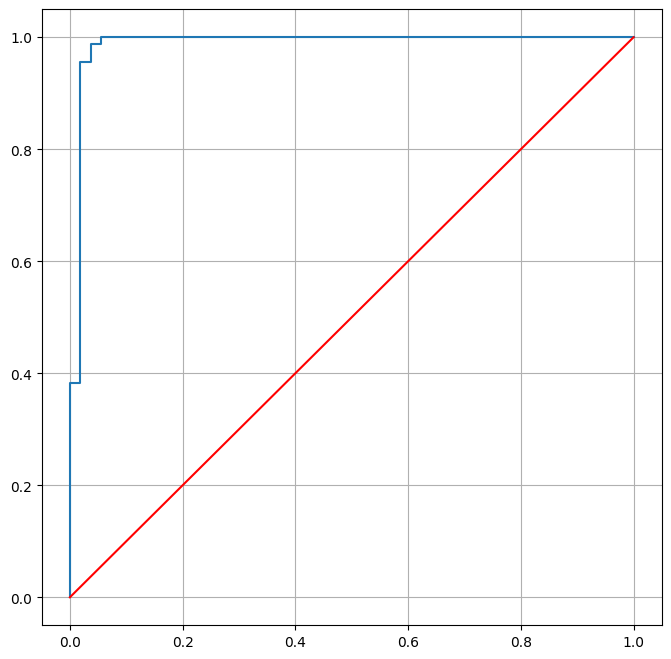

In [63]:
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1)
plt.plot([0, 1], [0, 1], color='red')
plt.grid()
plt.show()

##### ROC 곡선 예쁘게 시각화

<Figure size 800x800 with 0 Axes>

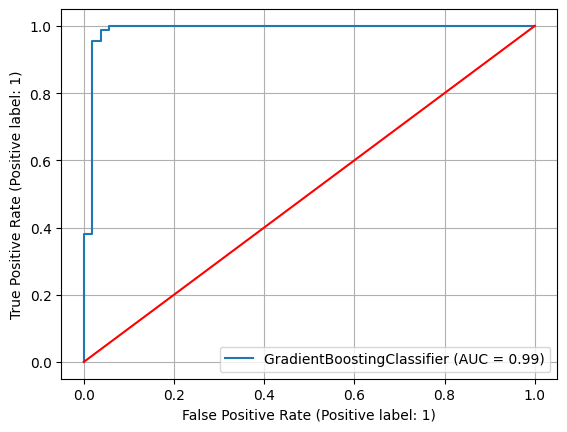

In [65]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(gb, x_test, y_test)
plt.plot([0, 1], [0, 1], color='red')
plt.grid()
plt.show()
plt.close()

### AUC 값 직접 계산

#### 실제 Label과 Positive의 예측 확률로 계산

In [66]:
print('roc_auc_score 함수 결과 :', roc_auc_score(y_test, score1))

roc_auc_score 함수 결과 : 0.9875156054931336


#### False Positive Rate와 True Positive Rate로 계산

In [67]:
print('auc 함수 결과 :', auc(fpr1, tpr1))

auc 함수 결과 : 0.9875156054931336


## #05. 하이퍼 파라미터 튜닝

| 파라미터 | 설명 |
| -- | -- |
| loss  | 경사 하강법에서 사용할 비용 함수를 지정<br/> `log_loss`(기본값 sklearn 1.3.1, 1.2.2는 `deviance`),  `exponential`  |
| learning_rate | GBM이 학습을 진행할 때마다 적용하는 학습률<br/> `0 ~ 1` 의 값(기본값=0.1) |
| n_estimators | 반복수 또는 base_estimator 개수(기본값=100) |
| subsample | weak learner가 학습에 사용하는 데이터의 샘플링 비율 (기본값=1)<br/> 과적합이 염려되는 경우 subsample을 1보다 작은 값으로 설정 |

In [68]:
# 부스팅에 사용할 학습 알고리즘 생성
dt = DecisionTreeClassifier(
    max_depth=2, min_samples_leaf=10, random_state=123
)

# 모델 생성
gb = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=1,
    n_estimators=10,
    subsample=0.8,
    min_samples_leaf=5,
    max_depth=3,
    random_state=100
)

# 사용할 파라미터 설정
params = {
    "loss": ["log_loss", "exponential"],
    "n_estimators": [3, 5, 10],
    "learning_rate": [0.1, 0.3, 0.5],
    "subsample": [0.5, 0.8, 1.0],
    "min_samples_leaf": [3, 5, 10],
    "max_depth": [2, 3, 4]
}

# 하이퍼파라미터 튜닝 모델
grid = GridSearchCV(gb, param_grid=params, cv=5, n_jobs=-1)
# 학습
grid.fit(x_sm, y_sm)

print("최적의 하이퍼 파라미터 :",grid.best_params_)
print("최적의 모델 평균 성능(훈련데이터) :",grid.best_score_)

# 검증 정확도 유도
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)
print("최종 모델의 성능(테스트 데이터) :", accuracy_score(y_test,y_pred))

최적의 하이퍼 파라미터 : {'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 10, 'subsample': 1.0}
최적의 모델 평균 성능(훈련데이터) : 0.9645898234683281
최종 모델의 성능(테스트 데이터) : 0.986013986013986


### 성능 검증

#### 분류 보고서

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.97      0.99      0.98        89

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



#### AUC, ROC 곡선

<Figure size 800x800 with 0 Axes>

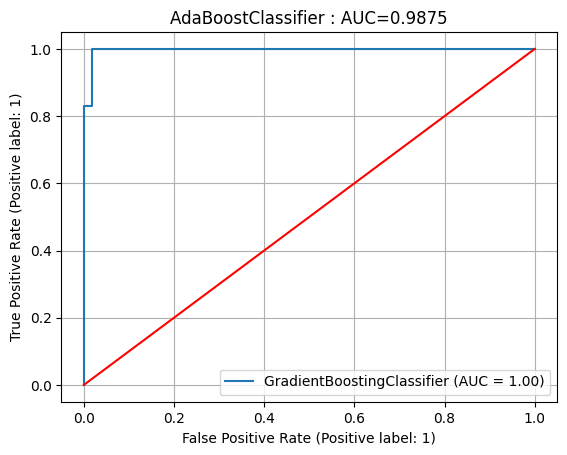

In [69]:
fpr1, tpr1, _ = roc_curve(y_test, score1)

plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(best_model, x_test, y_test)
plt.plot([0, 1], [0, 1], color='red')
plt.title("AdaBoostClassifier : AUC={0:0.4f}".format(auc(fpr1,tpr1)))
plt.grid()
plt.show()
plt.close()